In [16]:
#1
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("date_alegeri_turul2.csv")

varsta = data["Varsta"].values
gender = data["Sex"].values
educatie = data["Educatie"].values
venit = data["Venit"].values
y_vot = data["Vot"].values

with pm.Model() as model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    beta3 = pm.Normal("beta3", mu=0, sigma=10)
    beta4 = pm.Normal("beta4", mu=0, sigma=10)

    mu = beta0 + beta1 * varsta + beta2 * gender + beta3 * educatie + beta4 * venit
    y_obs = pm.Bernoulli("y_obs", p=pm.math.sigmoid(mu), observed=y_vot)


    trace = pm.sample(2000, tune=1000, idata_kwargs={"log_likelihood": True})

    waic2 = az.waic(trace)
    loo2 = az.loo(trace)
    print("WAIC:", waic2)
    print("LOO:", loo2)

    summary = az.summary(trace)
    print(summary)

    #(b) din summary putem vedea ca media cea mai mare este asociata lui beta1 si beta4, adica varsta si venitul vor variabilele care influenteaza cel mai mult rezultatul

Output()

Output()

WAIC: Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -211.78    12.76
p_waic        4.92        -
LOO: Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -211.79    12.77
p_loo        4.93        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      500  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0 -2.718  0.688  -4.039   -1.443      0.016    0.011    1821.0    2091.0   
beta1  0.030  0.013   0.005    0.054      0.000    0.000    2225.0    2230.0   
beta2 -0.852  0.251  -1.305   -0.379      0.004    0.003    3702.0    2734.0   
beta3  0.617  0.164   0.306    0.917      0.003    0.002    3215.0    2577.0   
beta4  0.498  0.071   0.363    0.629      0.001    0.001    2677.0   

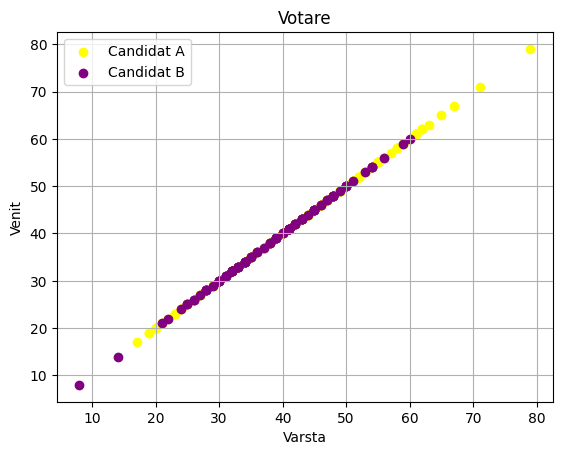

Output()

Output()

AttributeError: module 'arviz' has no attribute 'from_pymc'

In [20]:
#1 (c)
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("date_alegeri_turul2.csv")

varsta = data["Varsta"].values
venit = data["Venit"].values
y_vot = data["Vot"].values

#vizualizare initiala date
plt.scatter(varsta[y_vot==1], varsta[y_vot==1], color='yellow', label='Candidat A')
plt.scatter(varsta[y_vot==0], varsta[y_vot==0], color='purple', label='Candidat B')
plt.xlabel("Varsta")
plt.ylabel("Venit")
plt.title("Votare")
plt.legend()
plt.grid(True)
plt.show()

#standardizare date
medie_varsta_data, std_varsta_data = varsta.mean(axis=0), varsta.std(axis=0)
medie_venit_data, std_venit_data = venit.mean(axis=0), venit.std(axis=0)

varsta_data_st = (varsta - medie_varsta_data) / std_varsta_data #xi1
venit_data_st = (venit - medie_venit_data) / std_venit_data #xi2

with pm.Model() as model:
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    μ = beta0 + beta1 * varsta_data_st + beta2 * venit_data_st
    θ = pm.Deterministic('μ', pm.math.sigmoid(μ)) #pi = logistic(β0 + β1xi1 + β2xi2),

    y_obs = pm.Bernoulli("y_obs", p=θ, observed=y_vot)
    trace2 = pm.sample(2000, tune=1000, target_accept=0.9, idata_kwargs={"log_likelihood": True})
    idata2 = az.from_pymc(trace2)
    waic2 = az.waic(trace2)
    loo2 = az.loo(trace2)
    print("WAIC:", waic2)
    print("LOO:", loo2)

# esantioanele posterioare
esantion_beta0 = trace2.posterior["beta0"].values.flatten()
esantion_beta1 = trace2.posterior["beta1"].values.flatten()
esantion_beta2 = trace2.posterior["beta2"].values.flatten()

# (b)
varsta_values = np.linspace(varsta.min(), varsta.max(), 100)
varsta_values_st = (varsta - medie_varsta_data) / std_varsta_data

frontiere = []
for b0, b1, b2 in zip(esantion_beta0, esantion_beta1, esantion_beta2):
    frontiera_venit_st = -(b0 + b1 * varsta_values_st) / b2
    frontiera_venit = frontiera_venit_st * std_venit_data + medie_venit_data
    frontiere.append(frontiera_venit)
frontiere = np.array(frontiere)

frontiera_medie = np.mean(frontiere, axis=0)
interval_hdi = az.hdi(frontiere, hdi_prob=0.94)


plt.scatter(varsta, venit, c=y_vot)
plt.plot(varsta, frontiera_medie, color='k')
plt.fill_between(varsta, interval_hdi[:, 0], interval_hdi[:, 1], color='k', alpha=0.2)
plt.xlabel("Varsta")
plt.ylabel("Venit")
plt.title("Votare")
plt.grid(True)
plt.show()

idata1 = az.from_pymc(trace)
comparison = az.compare({"Model 1": idata1, "Model 2": idata2}, ic="waic")
print(comparison)

az.plot_compare(comparison)
plt.show()

In [1]:
#2
import pymc as pm
import numpy as np
import pandas as pd

data = pd.read_csv("iris.csv")

sepal_length = data["sepal_length"].values
sepal_width = data["sepal_width"].values
petal_length = data["petal_length"].values
caracteristici = np.stack([sepal_length, sepal_width, petal_length], axis=1)

with pm.Model() as model:

    mu = pm.Normal('mu', mu=0, sigma=10, shape=(3, 3))
    sigma = pm.HalfNormal('sigma', sigma=10, shape=(3, 3))


    cluster = pm.Categorical('cluster', p=np.ones(3)/3, shape=len(caracteristici))


    for i, feature_name in enumerate(['sepal_length', 'sepal_width', 'petal_length']):
        pm.Normal(f"{feature_name}_obs",
                  mu=mu[cluster, i],
                  sigma=sigma[cluster, i],
                  observed=caracteristici[:, i])


    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

summary = pm.summary(trace)
print(summary)


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
cluster[0]   1.500  0.500   1.000    2.000      0.353    0.299       2.0   
cluster[1]   1.500  0.500   1.000    2.000      0.353    0.299       2.0   
cluster[2]   1.500  0.500   1.000    2.000      0.353    0.299       2.0   
cluster[3]   1.500  0.500   1.000    2.000      0.353    0.299       2.0   
cluster[4]   1.500  0.500   1.000    2.000      0.353    0.299       2.0   
...            ...    ...     ...      ...        ...      ...       ...   
sigma[1, 1]  0.338  0.063   0.240    0.450      0.038    0.030       3.0   
sigma[1, 2]  0.373  0.200   0.143    0.645      0.138    0.116       3.0   
sigma[2, 0]  0.438  0.091   0.299    0.589      0.056    0.045       3.0   
sigma[2, 1]  0.335  0.065   0.230    0.444      0.040    0.032       3.0   
sigma[2, 2]  0.417  0.244   0.146    0.745      0.169    0.142       3.0   

             ess_tail       r_hat  
cluster[0]        2.0  4876400.29  
cluster[1]     